In [1]:
# Install pyclustering if not already installed
!pip install pyclustering
# For some reason, pyclustering breaks with more recent versions of numpy, so we need to force pip to install numpy==1.23.0
!pip install numpy==1.23.0

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from datasets import load_dataset
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from pyclustering.cluster.xmeans import xmeans, splitting_type
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


First, load the dataset. We only care about the numerical colums here so we can ignore the rest.

In [2]:
dataset = load_dataset('csv', data_files='../dataset/merged_FE_no_outliers.csv')
df = dataset['train'].to_pandas()
X = df.select_dtypes(include='number').dropna()

Next we look at the correlation matrix of our features. We want to drop highly-correlated columns because redundant information skews the distance metrics using in clustering.

In [3]:
correlation_matrix = X.corr()
correlation_matrix

,points,uci_points,length,climb_total,profile,startlist_quality,position,cyclist_age,delta,year,...,top_x_finish_percentage,consistency_score,birth_year,weight,height,BMI,PWR,climb_efficiency,time_gap,prestige_weighted_delta
points,1.000000,0.853342,0.363290,0.132852,-0.084936,0.165857,-0.074696,-0.014053,0.006522,-0.151348,...,0.106486,0.004265,-0.145632,0.049365,0.018183,0.052966,0.846745,-0.074721,-0.001424,-0.013295
uci_points,0.853342,1.000000,0.360222,0.136147,-0.068276,-0.067435,-0.119541,-0.010874,0.007096,-0.032263,...,0.088754,0.009057,-0.028376,0.038787,0.023983,0.030597,0.993869,-0.119562,-0.001542,-0.010211
length,0.363290,0.360222,1.000000,0.536474,0.104751,0.074533,-0.012915,0.003193,0.012997,-0.048111,...,0.043154,0.004307,-0.048889,0.026338,0.009500,0.028356,0.356475,-0.013038,-0.008474,0.002830
climb_total,0.132852,0.136147,0.536474,1.000000,0.687797,0.036470,-0.038109,0.002595,0.026806,0.017133,...,0.012830,0.003661,0.016146,-0.014494,-0.002268,-0.018722,0.139744,-0.038199,-0.003840,0.017580
profile,-0.084936,-0.068276,0.104751,0.687797,1.000000,-0.066044,-0.015705,0.010718,0.023236,0.122796,...,-0.038206,-0.001122,0.118390,-0.030813,-0.001688,-0.044064,-0.064713,-0.015761,-0.000671,0.019938
startlist_quality,0.165857,-0.067435,0.074533,0.036470,-0.066044,1.000000,0.145703,0.037555,-0.005077,-0.216792,...,0.076566,-0.021439,-0.228141,0.056553,0.016629,0.065781,-0.067185,0.145684,-0.002024,-0.010942
position,-0.074696,-0.119541,-0.012915,-0.038109,-0.015705,0.145703,1.000000,0.012024,0.008961,0.134739,...,-0.297947,-0.034761,0.129815,0.095590,0.074276,0.056390,-0.123718,1.000000,0.001188,0.009190
cyclist_age,-0.014053,-0.010874,0.003193,0.002595,0.010718,0.037555,0.012024,1.000000,-0.002841,0.151696,...,0.033424,-0.010730,-0.187939,0.040151,-0.005381,0.064619,-0.013521,0.012024,0.000420,-0.001359
delta,0.006522,0.007096,0.012997,0.026806,0.023236,-0.005077,0.008961,-0.002841,1.000000,-0.002915,...,0.000293,-0.001549,-0.001935,0.004420,0.003431,0.002705,0.006818,0.008960,0.758078,0.970606
year,-0.151348,-0.032263,-0.048111,0.017133,0.122796,-0.216792,0.134739,0.151696,-0.002915,1.000000,...,-0.296567,-0.055732,0.942304,-0.052154,0.069376,-0.158894,-0.029719,0.134746,-0.001288,0.003265


In [4]:
columns_to_keep = ['BMI', 'race_difficulty','team_avg_strength','consistency_score', 'PWR', 'climb_efficiency','prestige_weighted_delta', 'length', 'cyclist_age', ]
X_no_correlations = X[columns_to_keep]
display(X_no_correlations)
print("Filtered dataset shape:", X_no_correlations.shape)

,BMI,race_difficulty,team_avg_strength,consistency_score,PWR,climb_efficiency,prestige_weighted_delta,length,cyclist_age
0,20.795020,0.225995,1117.306216,0.003283,6.776599,0.000254,0.000000,240000.0,24.0
1,23.106614,0.225995,1117.306216,0.065637,5.355048,1.000254,0.000000,240000.0,26.0
2,22.839506,0.225995,1098.066569,0.001798,5.405405,2.000254,0.097778,240000.0,23.0
3,20.112519,0.225995,1098.066569,0.005988,5.737784,3.000254,0.048889,240000.0,24.0
4,21.153068,0.225995,1121.314981,0.001331,5.795992,4.000254,0.000000,240000.0,23.0
...,...,...,...,...,...,...,...,...,...
576373,23.889463,0.238958,1070.070046,0.000050,8.108108,97.000240,0.000000,266900.0,25.0
576374,19.662026,0.238958,1103.503179,0.000104,8.108108,99.000240,0.034286,266900.0,23.0
576375,19.805342,0.238958,1103.503179,0.000064,8.571429,100.000240,0.480000,266900.0,25.0
576376,20.598608,0.238958,1117.479352,0.000041,9.090909,101.000240,0.105714,266900.0,23.0


Filtered dataset shape: (576378, 9)


Next, we'll standardize our features using StandardScaler. This is extremely important, because otherwise features with large values will have a disproportional impact on the distance calculations of the clustering algorithm

In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_no_correlations)

We'll try and find the optimal parameters for dbscan by performing a grid search. Note that this takes several hours to execute. As part of the parameters we test, we'll also try various values of PCA. It's a good idea to apply PCA to reduce the odds of being affected by the curse of dimensionality.

In [ ]:
# Configure our parameters for the grid search
pca_dimensions = [2, 3, 5]
initial_k_values = [2, 3, 4, 5]

best_score = -1
best_params = None

# Run grid search
for n_components in pca_dimensions:
    # Apply PCA to reduce dimensionality
    pca = PCA(n_components=n_components)
    X_pca_full = pca.fit_transform(X_scaled)

    print(f"\nTesting PCA dimensions: {n_components}")
    print(f"Explained Variance Ratio: {pca.explained_variance_ratio_}")
    print(f"Cumulative Variance: {sum(pca.explained_variance_ratio_)}")

    # Randomly sample a subset of the data for efficiency (10%)
    sample_fraction = 0.1
    sample_size = int(sample_fraction * X_pca_full.shape[0])
    indices = np.random.choice(X_pca_full.shape[0], size=sample_size, replace=False)
    X_pca = X_pca_full[indices]

    for initial_k in initial_k_values:
        # Define initial centers using k-means++ initializer on the sampled data
        initial_centers = kmeans_plusplus_initializer(X_pca, initial_k).initialize()

        # Create X-means instance
        xmeans_instance = xmeans(data=X_pca, initial_centers=initial_centers)

        # Run cluster analysis
        xmeans_instance.process()

        # Get clusters and centers
        clusters = xmeans_instance.get_clusters()
        centers = xmeans_instance.get_centers()

        # Get labels for each data point in the sample
        labels = np.empty(X_pca.shape[0])
        for cluster_id, cluster in enumerate(clusters):
            labels[cluster] = cluster_id

        # Compute silhouette score if more than one cluster is found
        if len(np.unique(labels)) > 1:
            score = silhouette_score(X_pca, labels)
            print(f"Initial k={initial_k}, Number of clusters={len(clusters)}, Silhouette Score={score:.4f}")
        else:
            score = -1  # Assign a low score if only one cluster is found
            print(f"Initial k={initial_k}, Number of clusters={len(clusters)}, Only one cluster found.")

        # Update the best parameters if current score is better
        if score > best_score:
            best_score = score
            best_params = {
                'n_components': n_components,
                'initial_k': initial_k,
                'n_clusters': len(clusters),
                'labels': labels.copy(),
                'centers': centers,
                'indices': indices.copy()
            }

# Output the best parameters
if best_params:
    print("\nBest Parameters:")
    print(f"n_components={best_params['n_components']}, initial_k={best_params['initial_k']}, "
          f"Number of clusters={best_params['n_clusters']}, Best Silhouette Score={best_score:.4f}")




Testing PCA dimensions: 2
Explained Variance Ratio: [0.16205252 0.12311794]
Cumulative Variance: 0.28517045703768396
Initial k=2, Number of clusters=5, Silhouette Score=0.3810
Initial k=3, Number of clusters=7, Silhouette Score=0.3381
Initial k=4, Number of clusters=5, Silhouette Score=0.3810
Initial k=5, Number of clusters=6, Silhouette Score=0.3377

Testing PCA dimensions: 3
Explained Variance Ratio: [0.16205252 0.12311794 0.11687529]
Cumulative Variance: 0.4020457423643157
Initial k=2, Number of clusters=8, Silhouette Score=0.2894
Initial k=3, Number of clusters=6, Silhouette Score=0.3035
Initial k=4, Number of clusters=6, Silhouette Score=0.2893
Initial k=5, Number of clusters=9, Silhouette Score=0.2900

Testing PCA dimensions: 5
Explained Variance Ratio: [0.16205252 0.12311794 0.11687529 0.11224435 0.11073274]
Cumulative Variance: 0.6250228311848194
Initial k=2, Number of clusters=18, Silhouette Score=0.1966
Initial k=3, Number of clusters=12, Silhouette Score=0.2211
Initial k=4,

Next, we'll use our best parameters to run the clustering on the entire dataset.

In [ ]:
n_components = 3
initial_k = 3

pca = PCA(n_components=n_components)
X_pca_full = pca.fit_transform(X_scaled)

# Randomly sample a subset of the data for efficiency (10%)
sample_fraction = 0.1
sample_size = int(sample_fraction * X_pca_full.shape[0])
indices = np.random.choice(X_pca_full.shape[0], size=sample_size, replace=False)
X_pca = X_pca_full[indices]
df_sampled = df.iloc[indices].copy()

print("Explained Variance Ratio:", pca.explained_variance_ratio_)
print("Cumulative Variance:", sum(pca.explained_variance_ratio_))

# Apply X-means clustering
initial_centers = kmeans_plusplus_initializer(X_pca, initial_k).initialize()
xmeans_instance = xmeans(data=X_pca, initial_centers=initial_centers)
xmeans_instance.process()

clusters = xmeans_instance.get_clusters()
centers = xmeans_instance.get_centers()

labels = np.empty(X_pca.shape[0])
for cluster_id, cluster in enumerate(clusters):
    labels[cluster] = cluster_id

# Check how good the clustering is by calculating the silhouette score
if len(np.unique(labels)) > 1:
    score = silhouette_score(X_pca, labels)
    print(f"Silhouette Score: {score:.4f}")
else:
    print("Only one cluster found.")
    score = -1

df_sampled['xmeans_cluster'] = labels.astype(int)
print(df_sampled['xmeans_cluster'].value_counts())

Explained Variance Ratio: [0.16205252 0.12311794 0.11687529]
Cumulative Variance: 0.40204574236432433
Silhouette Score: 0.3034
xmeans_cluster
3    2191
1    2072
0    1045
4     453
2       2
Name: count, dtype: int64


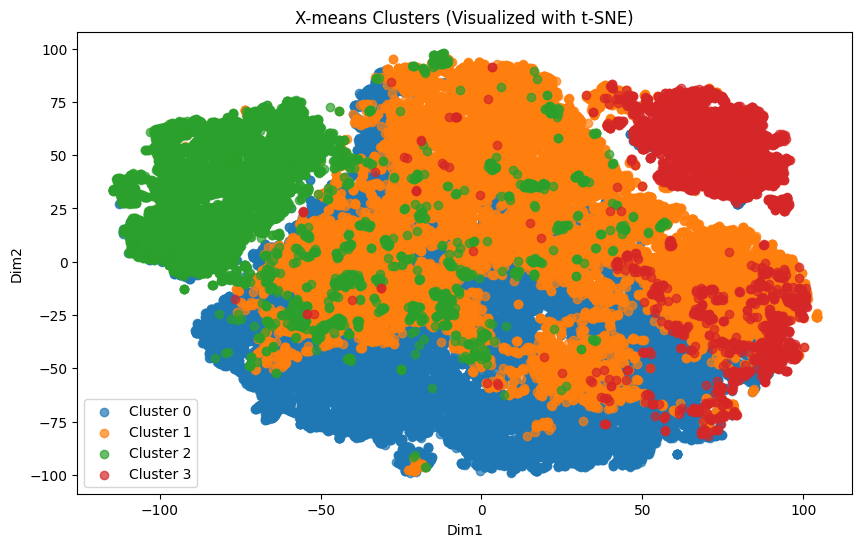

In [13]:
from sklearn.manifold import TSNE

X_scaled_sampled = X_scaled[indices]

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled_sampled)

df_viz = pd.DataFrame(X_tsne, columns=['Dim1', 'Dim2'])

df_sampled_reset_indexes = df_sampled.reset_index(drop=True)
df_viz['Cluster'] = df_sampled_reset_indexes['xmeans_cluster']

plt.figure(figsize=(10, 6))
for cluster in sorted(df_viz['Cluster'].unique()):
    subset = df_viz[df_viz['Cluster'] == cluster]
    plt.scatter(
        subset['Dim1'],
        subset['Dim2'],
        label=f'Cluster {int(cluster)}',
        alpha=0.7
    )

plt.title('X-means Clusters (Visualized with t-SNE)')
plt.xlabel('Dim1')
plt.ylabel('Dim2')
plt.legend()
plt.show()


In [10]:
from sklearn.manifold import TSNE
import pandas as pd

# Ensure sampling indices are consistent
X_scaled_sampled = X_scaled[indices]

# Run 3D t-SNE
tsne_3d = TSNE(n_components=3, perplexity=30, random_state=42)
X_tsne_3d = tsne_3d.fit_transform(X_scaled_sampled)

# Reset indices for consistent alignment with cluster labels
df_sampled_reset_indexes = df_sampled.reset_index(drop=True)

# Create DataFrame for visualization
df_tsne = pd.DataFrame(X_tsne_3d, columns=['Dim1', 'Dim2', 'Dim3'])
df_tsne['Cluster'] = df_sampled_reset_indexes['xmeans_cluster']

# Plot the 3D visualization using Plotly
fig = px.scatter_3d(
    df_tsne,
    x='Dim1',
    y='Dim2',
    z='Dim3',
    color='Cluster',
    title='3D t-SNE Clusters',
    labels={'Cluster': 'Cluster'},
    opacity=0.7
)

fig.update_traces(marker=dict(size=5))
fig.update_layout(scene=dict(
    xaxis_title='Dim1',
    yaxis_title='Dim2',
    zaxis_title='Dim3'
))
fig.show()


# 2D Scatterplot

Let's create a 2-d scatterplot of our results to see if some obvious clusters appear.

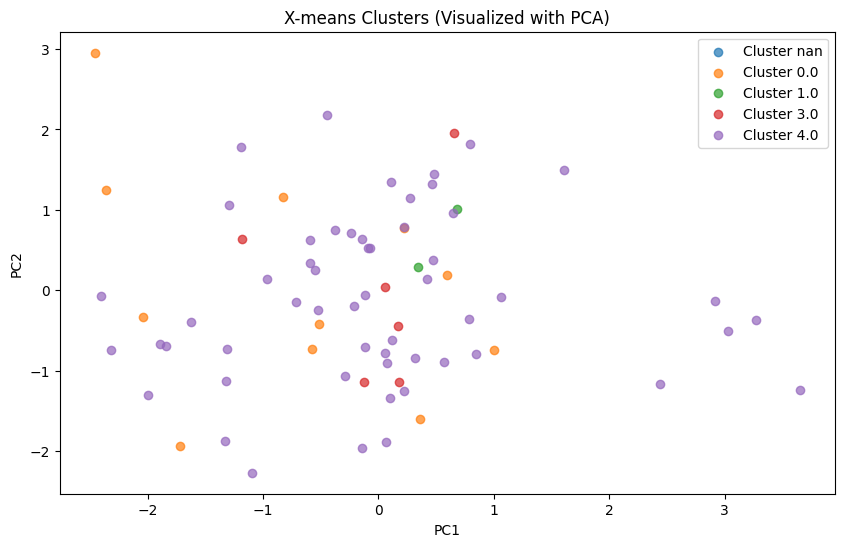

In [ ]:
df_viz = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_viz['Cluster'] = df_sampled['xmeans_cluster']

# Visualize the clusters (using PC1 and PC2 for a 2D plot)
plt.figure(figsize=(10, 6))
for cluster in sorted(df_viz['Cluster'].unique()):
    subset = df_viz[df_viz['Cluster'] == cluster]
    plt.scatter(
        subset['PC1'], 
        subset['PC2'], 
        label=f'Cluster {cluster}' if cluster != -1 else 'Noise', 
        alpha=0.7
    )

plt.title('X-means Clusters (Visualized with PCA)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

On our 2d-plot, we don't see any obvious clusters. This might be because the clusters are not easily separable in 2 dimensions. We'll try vizualising the data in 3D to see if we can spot clusters more easily.

# 3D plot with plotly

In [13]:
# Convert cluster labels to strings for proper categorical coloring in Plotly
df_viz = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])
df_viz['Cluster'] = df_sampled['xmeans_cluster']

# Create the interactive 3D scatter plot
fig = px.scatter_3d(
    df_viz,
    x='PC1',
    y='PC2',
    z='PC3',
    color='Cluster',
    title='DBSCAN Clusters (Visualized with PCA)',
    opacity=0.7
)

fig.update_traces(marker=dict(size=5))
fig.update_layout(
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    legend_title='Cluster'
)

fig.show()

As we can see from these vizualizations, there doesn't appear to be well-defined clusters. Considering that DBSCAN assumes that clusters are dense regions of points separated by sparse regions, it makes sense that it isn't able to identify reasonable clusters in our data.